# Emotion Detection in Movie Shots

This notebook analyzes facial emotions in keyframe images from detected movie shots.
We'll use the DeepFace library to detect faces and their emotions, then link these emotions
back to shots and timestamps in the movie.

## Setup

First, let's import the required libraries and ensure we have all dependencies:

In [1]:
# Install necessary packages if not already installed
!pip install deepface matplotlib pandas numpy tqdm

# Import required libraries
import os
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from deepface import DeepFace
from glob import glob
from tqdm.notebook import tqdm
import warnings
warnings.filterwarnings('ignore')

# Create output directory if it doesn't exist
os.makedirs('outputs', exist_ok=True)



25-04-12 20:54:49 - Directory C:\Users\Saurabh\.deepface has been created
25-04-12 20:54:49 - Directory C:\Users\Saurabh\.deepface\weights has been created


## Load Keyframe Images

Next, we'll load all keyframe images from the `outputs/shots/` directory:

In [2]:
# Get all shot keyframe files
shot_files = sorted(glob('outputs/shots/shot_*_frame_*.jpg'))

print(f"Found {len(shot_files)} shot keyframes.")

# Display first few files to verify
shot_files[:5]


Found 93 shot keyframes.


['outputs/shots\\shot_000_frame_1647.jpg',
 'outputs/shots\\shot_001_frame_00114.jpg',
 'outputs/shots\\shot_002_frame_00175.jpg',
 'outputs/shots\\shot_003_frame_00263.jpg',
 'outputs/shots\\shot_004_frame_00285.jpg']

## Extract Shot Information

We need to extract the shot ID and frame number from each filename:

In [3]:
# Function to extract shot ID and frame number from filename
def extract_shot_info(filename):
    # Extract with regex - using raw string to avoid escape sequence warnings
    match = re.search(r'shot_(\d+)_frame_(\d+)', filename)
    if match:
        shot_id = int(match.group(1))
        frame_num = int(match.group(2))
        
        # Calculate approximate timestamp (assuming 30fps)
        timestamp = frame_num / 30.0  
        
        return {
            'filename': filename,
            'shot_id': shot_id,
            'frame': frame_num,
            'timestamp': timestamp
        }
    return None

# Process all files
shot_data = []
for file in shot_files:
    info = extract_shot_info(file)
    if info:
        shot_data.append(info)

# Create DataFrame
shot_df = pd.DataFrame(shot_data)
print(f"Extracted information for {len(shot_df)} shots")
shot_df.head()


Extracted information for 93 shots


,filename,shot_id,frame,timestamp
0,outputs/shots\shot_000_frame_1647.jpg,0,1647,54.900000
1,outputs/shots\shot_001_frame_00114.jpg,1,114,3.800000
2,outputs/shots\shot_002_frame_00175.jpg,2,175,5.833333
3,outputs/shots\shot_003_frame_00263.jpg,3,263,8.766667
4,outputs/shots\shot_004_frame_00285.jpg,4,285,9.500000


## Emotion Detection with DeepFace

Now we'll use DeepFace to detect faces and emotions in each keyframe:

In [4]:
# Function to detect emotions in an image
def detect_emotions(image_path):
    try:
        # Analyze the image using DeepFace
        result = DeepFace.analyze(
            img_path=image_path,
            actions=['emotion'],
            enforce_detection=False,  # Don't raise error if no face detected
            detector_backend='opencv'  # Use OpenCV for faster detection
        )
        
        # If a list is returned (multiple faces), take the first face
        if isinstance(result, list):
            if len(result) > 0:
                result = result[0]
            else:
                return None, 0.0
                
        # Get dominant emotion and its score
        emotion = result['dominant_emotion']
        emotion_score = result['emotion'][emotion]
        
        return emotion, emotion_score
    except Exception as e:
        print(f"Error processing {image_path}: {str(e)}")
        return None, 0.0

# Process all images and detect emotions
print("Detecting emotions in keyframes...")
results = []

for _, row in tqdm(shot_df.iterrows(), total=len(shot_df)):
    emotion, confidence = detect_emotions(row['filename'])
    
    results.append({
        'shot_id': row['shot_id'],
        'timestamp': row['timestamp'],
        'emotion': emotion,
        'confidence': confidence
    })

# Create DataFrame with results
emotion_df = pd.DataFrame(results)
emotion_df = emotion_df.dropna(subset=['emotion'])  # Remove rows where no emotion was detected

print(f"Successfully detected emotions in {len(emotion_df)} shots")
emotion_df.head()


Detecting emotions in keyframes...


  0%|          | 0/93 [00:00<?, ?it/s]

25-04-12 20:55:08 - facial_expression_model_weights.h5 will be downloaded...


Downloading...
From: https://github.com/serengil/deepface_models/releases/download/v1.0/facial_expression_model_weights.h5
To: C:\Users\Saurabh\.deepface\weights\facial_expression_model_weights.h5

  0%|                                                                                                        | 0.00/5.98M [00:00<?, ?B/s]
  9%|████████▍                                                                                       | 524k/5.98M [00:00<00:01, 3.87MB/s]
 26%|████████████████████████▉                                                                      | 1.57M/5.98M [00:00<00:00, 7.06MB/s]
 44%|█████████████████████████████████████████▋                                                     | 2.62M/5.98M [00:00<00:00, 7.58MB/s]
 61%|██████████████████████████████████████████████████████████▎                                    | 3.67M/5.98M [00:00<00:00, 6.25MB/s]
 79%|██████████████████████████████████████████████████████████████████████████▉                    | 4.72M/5.98

Successfully detected emotions in 93 shots


,shot_id,timestamp,emotion,confidence
0,0,54.900000,angry,55.652107
1,1,3.800000,happy,99.353828
2,2,5.833333,happy,95.387917
3,3,8.766667,fear,99.879440
4,4,9.500000,sad,99.992455


## Save Results

Let's save the results to a CSV file:

In [5]:
# Save to CSV
output_file = 'outputs/shot_emotions.csv'
emotion_df.to_csv(output_file, index=False)
print(f"Results saved to {output_file}")


Results saved to outputs/shot_emotions.csv


## Data Visualization

Now let's visualize the emotion progression throughout the movie:

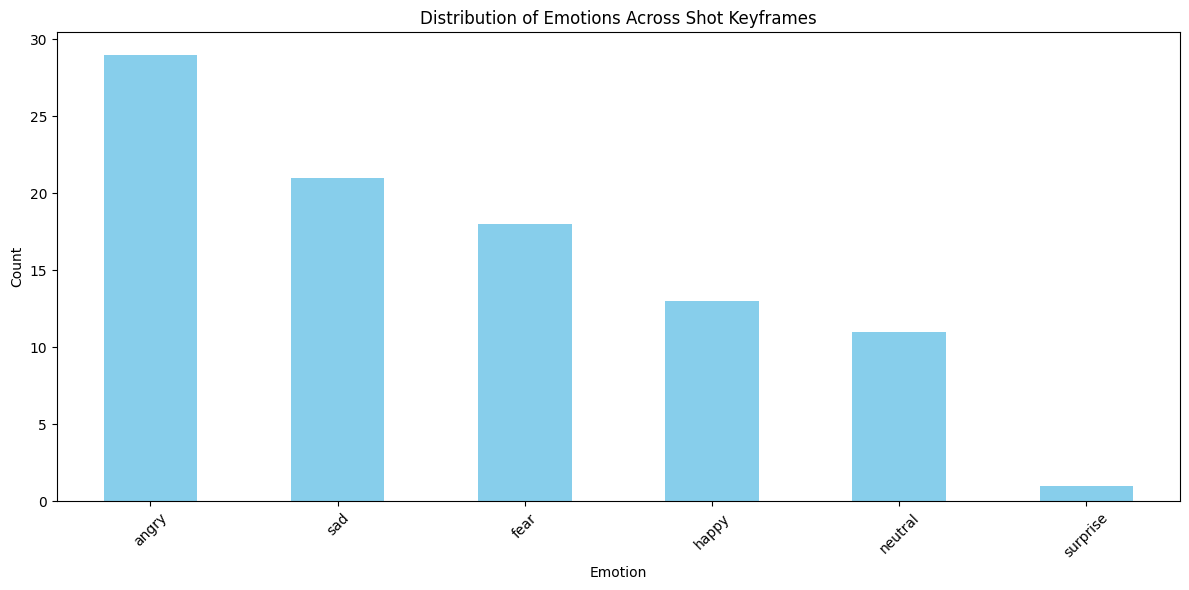

In [6]:
# Count occurrences of each emotion
emotion_counts = emotion_df['emotion'].value_counts()

# Plot emotion distribution
plt.figure(figsize=(12, 6))
emotion_counts.plot(kind='bar', color='skyblue')
plt.title('Distribution of Emotions Across Shot Keyframes')
plt.xlabel('Emotion')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


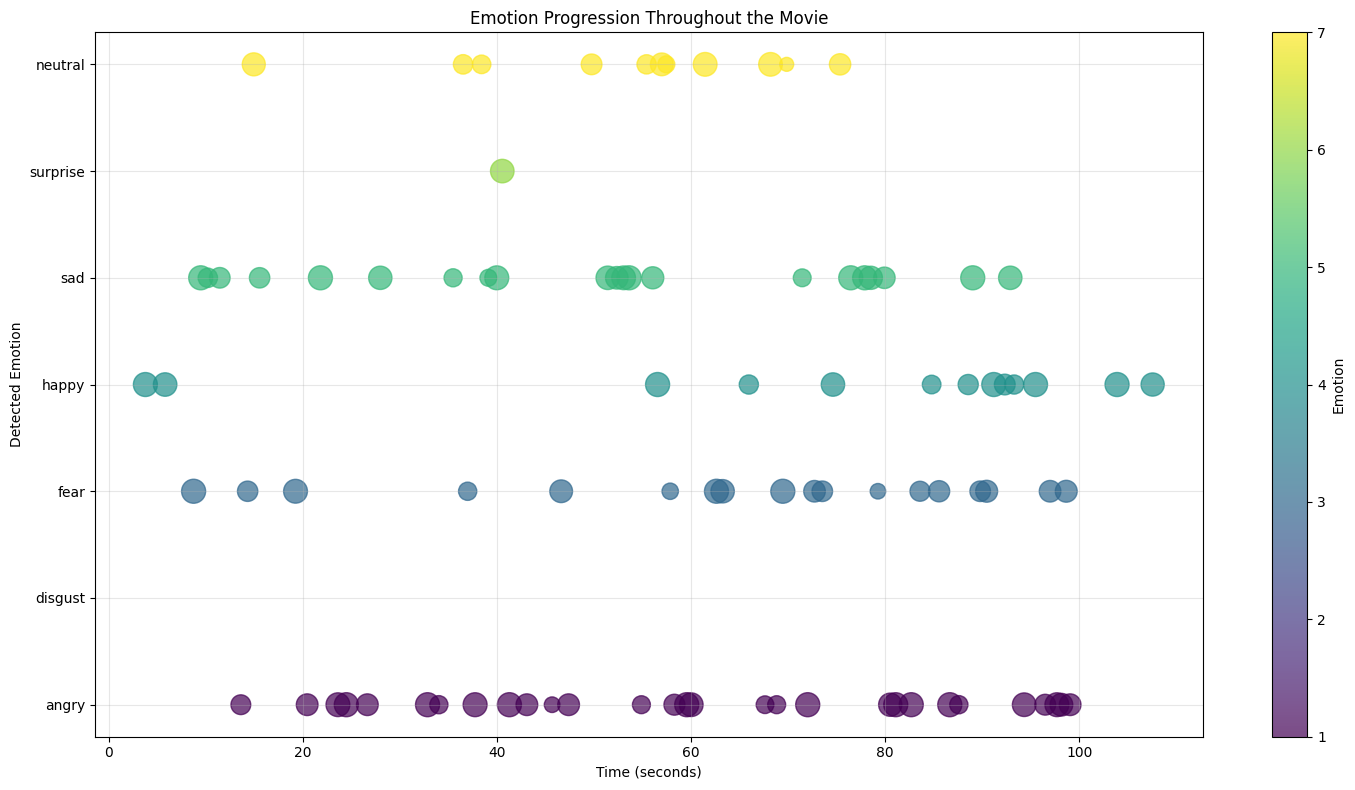

In [7]:
# Create a mapping of emotions to numeric values for plotting
emotion_map = {
    'angry': 1,
    'disgust': 2,
    'fear': 3,
    'happy': 4,
    'sad': 5,
    'surprise': 6,
    'neutral': 7
}

# Add numeric emotion value
emotion_df['emotion_value'] = emotion_df['emotion'].map(lambda x: emotion_map.get(x, 0))

# Sort by timestamp
timeline_df = emotion_df.sort_values(by='timestamp')

# Plot emotion over time with confidence as marker size
plt.figure(figsize=(15, 8))
plt.scatter(
    timeline_df['timestamp'],
    timeline_df['emotion_value'],
    c=timeline_df['emotion_value'],
    s=timeline_df['confidence'] * 3,  # Size based on confidence
    cmap='viridis',
    alpha=0.7
)

# Set y-ticks to emotion names
plt.yticks(list(emotion_map.values()), list(emotion_map.keys()))
plt.title('Emotion Progression Throughout the Movie')
plt.xlabel('Time (seconds)')
plt.ylabel('Detected Emotion')
plt.colorbar(ticks=list(emotion_map.values()), label='Emotion')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


## Summary and Insights

This analysis provides insights into the emotional tone throughout the movie.
By analyzing facial expressions in each shot:

- We can map the emotional journey of the film
- Identify key emotional moments or shifts
- Quantify the emotional tone distribution

This information could be useful for film analysis, trailer creation, or automatic summarization.

### Next Steps

- Combine this emotional analysis with audio sentiment analysis
- Map emotions to script or dialogue
- Group consecutive shots with similar emotions to identify emotional segments
